In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import dirichlet, multinomial

np.random.seed(37)

# number of topics
K = 10
# number of words
N = 100
# number of documents
M = 1000

# priors on K topics
a = np.array([0.1, 0.2, 0.3, 0.4, 0.025, 0.015, 0.37, 0.88, 0.03, 0.08])
# priors on N words
b = np.full((1, N), 0.001, dtype=float)[0]

In [2]:
# distribution of words in topic k
psi = np.array([dirichlet.rvs(b)[0] for _ in range(K)])
print(psi.shape)

(10, 100)


In [3]:
# distribution of topics in document d
theta = np.array([dirichlet.rvs(a)[0] for _ in range(M)])
print(theta.shape)

(1000, 10)


In [4]:
docs = []
for i in range(M):
    d = {}
    for j in range(N):
        z_ij = multinomial.rvs(1, theta[i])
        topic = np.argmax(z_ij)
        
        w_ij = multinomial.rvs(1, psi[topic])
        word = np.argmax(w_ij)
        
        if word not in d:
            d[word] = 0
        d[word] = d[word] + 1
    docs.append(d)

In [5]:
from scipy.sparse import lil_matrix

X = lil_matrix((M, N), dtype=np.int16)
for i, d in enumerate(docs):
    counts = sorted(list(d.items()), key=lambda tup: tup[0])
    for tup in counts:
        X[i, tup[0]] = tup[1]

In [6]:
print(X.shape)

(1000, 100)


In [7]:
means = X.mean(axis=0)
means = [(i, means[0, i]) for i in range(means.shape[1]) if means[0, i] > 0.0]

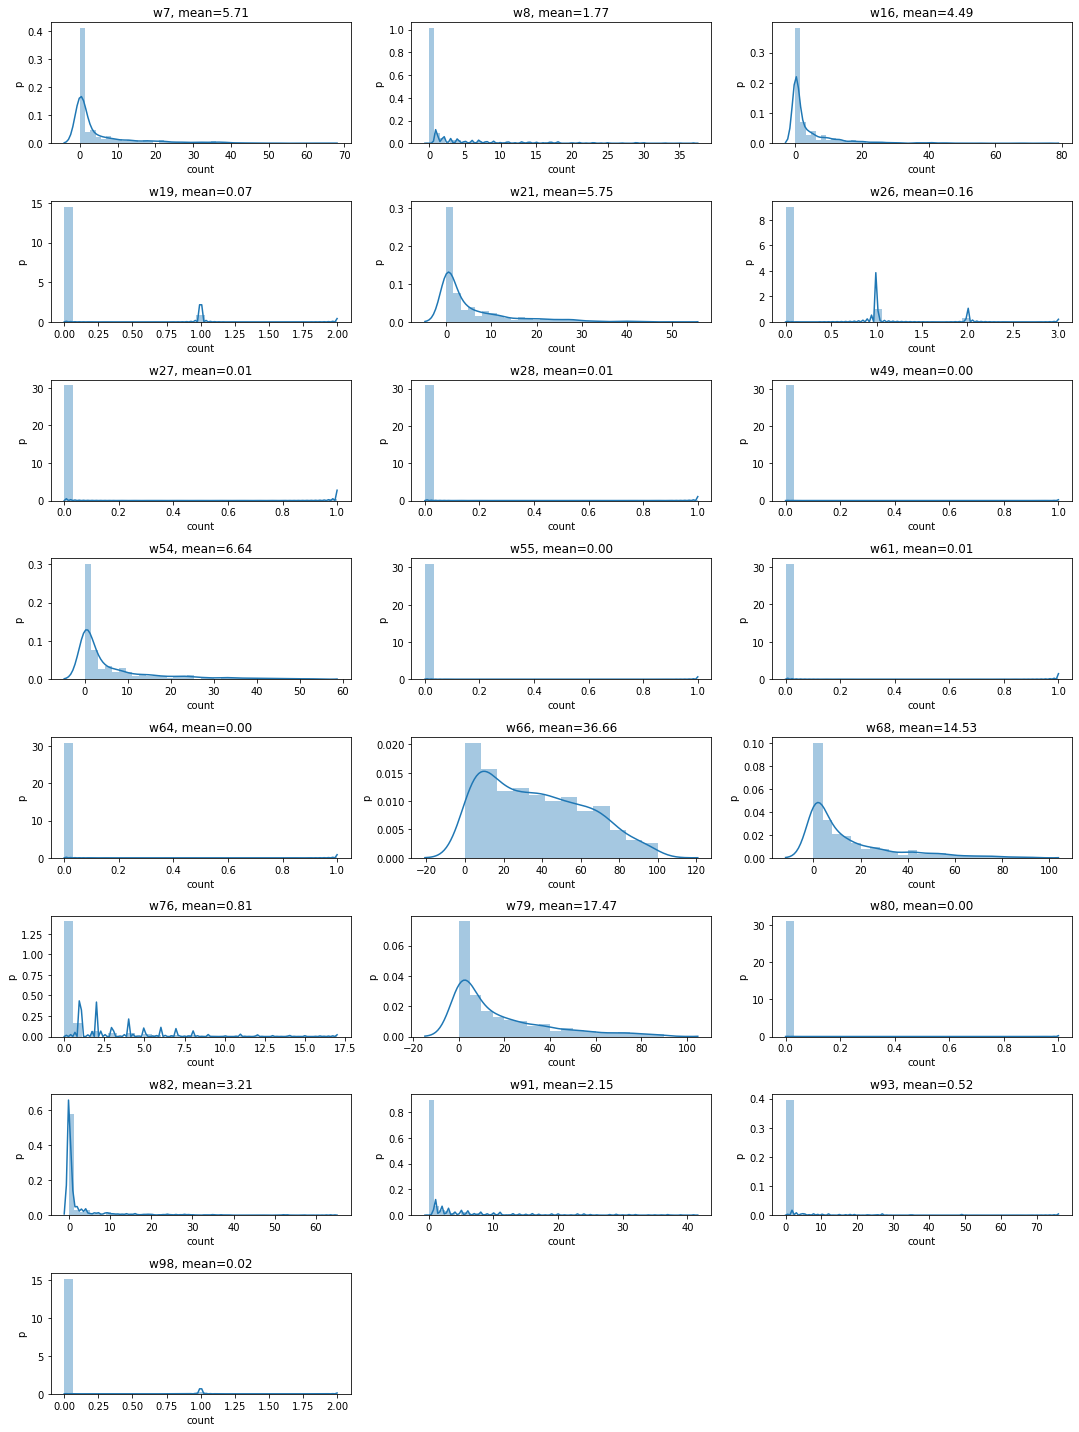

In [11]:
import math

n = len(means)
n_cols = 3
n_rows = math.ceil(n / n_cols)
is_even = True if n % n_cols > 0 else False
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 20))
ax = np.ravel(ax)

for i in range(len(ax)):
    if i < len(means):
        idx = means[i][0]
        mu = means[i][1]
        data = X[:,idx].toarray().reshape(1, -1)[0]
        sns.distplot(data, ax=ax[i])
        ax[i].set_title('w{}, mean={:.2f}'.format(idx, mu))
        ax[i].set_ylabel('p')
        ax[i].set_xlabel('count')
    else:
        ax[i].axis('off')

plt.tight_layout()